# Graph Theoretical Analysis

In [1]:
import os
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import SigProc
from analysis import graph_analysis_utils as gau
from analysis import analysis_utils as au
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.expanduser("~") + "/Hen_Lab/Mice/EPM"

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

animal_data_files = dict()

for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    if subdir_list:
        mice_directories = subdir_list

    for file_name in file_list:
        for mouse_name in mice_directories:
            if file_name.endswith(".csv") and (mouse_name in file_name and "behavior" in file_name):
                if mouse_name in animal_data_files:
                    animal_data_files[mouse_name].update({"behavior":dir_name+"/"+file_name})
                else:
                    animal_data_files[mouse_name] = {"behavior":dir_name+"/"+file_name}
            elif file_name.endswith(".csv") and (mouse_name in file_name and "Raw" in file_name):
                if mouse_name in animal_data_files:
                    animal_data_files[mouse_name].update({"Raw":dir_name+"/"+file_name})
                else:
                    animal_data_files[mouse_name] = {"Raw":dir_name+"/"+file_name}

## Store all neuron activity and corresponding behavior dataframes, for each animal, in a dictionary

In [4]:
animal_dataframes = dict()

for animal_name in animal_data_files:
    print(animal_name)
    
    data = pd.read_csv(animal_data_files[animal_name]["Raw"], header=None)
    if(animal_name=='drd73' or animal_name =='drd77'):
        data = au.downsample_dataframe(data,2)
    _, _, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)
    
    # Rename all the columns from "neuron_x" --> "x". This makes the graphs neater by making sure the neuron names fit into the nodes
    cell_transients_dataframe.columns = [i for i in range(1, len(cell_transients_dataframe.columns)+1)]
    
    behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

    behavior_df = pd.read_csv(animal_data_files[animal_name]["behavior"], header=None)
    behavior_df.columns = behavior_column_names
    
    # Only keep every 3rd row of the original behavior dataframe in order to downsample 30 fps --> 10 fps
    behavior_df = au.downsample_dataframe(behavior_df, 3)

    # Define cutoff for what constitutes as a running frame
    VELOCITY_CUTOFF = 4;

    # Adds "Running_frames" column to the end of the behavior dataframe 
    behavior_df["Running_frames"] = np.where(behavior_df["Velocity"] > VELOCITY_CUTOFF, 1, 0)
    
    neuron_concated_behavior = cell_transients_dataframe.join(behavior_df, how="left")
    
    if not animal_name in animal_dataframes:
        animal_dataframes[animal_name] = {"cell transients": cell_transients_dataframe, "behavior": behavior_df, "neuron and beh": neuron_concated_behavior}

drd46
drd73
drd77
drd87


## Compute all network measures for each mouse, and store them in a dictionary

In [ ]:
animal_dataframes[]

ValueError: not enough values to unpack (expected 2, got 0)

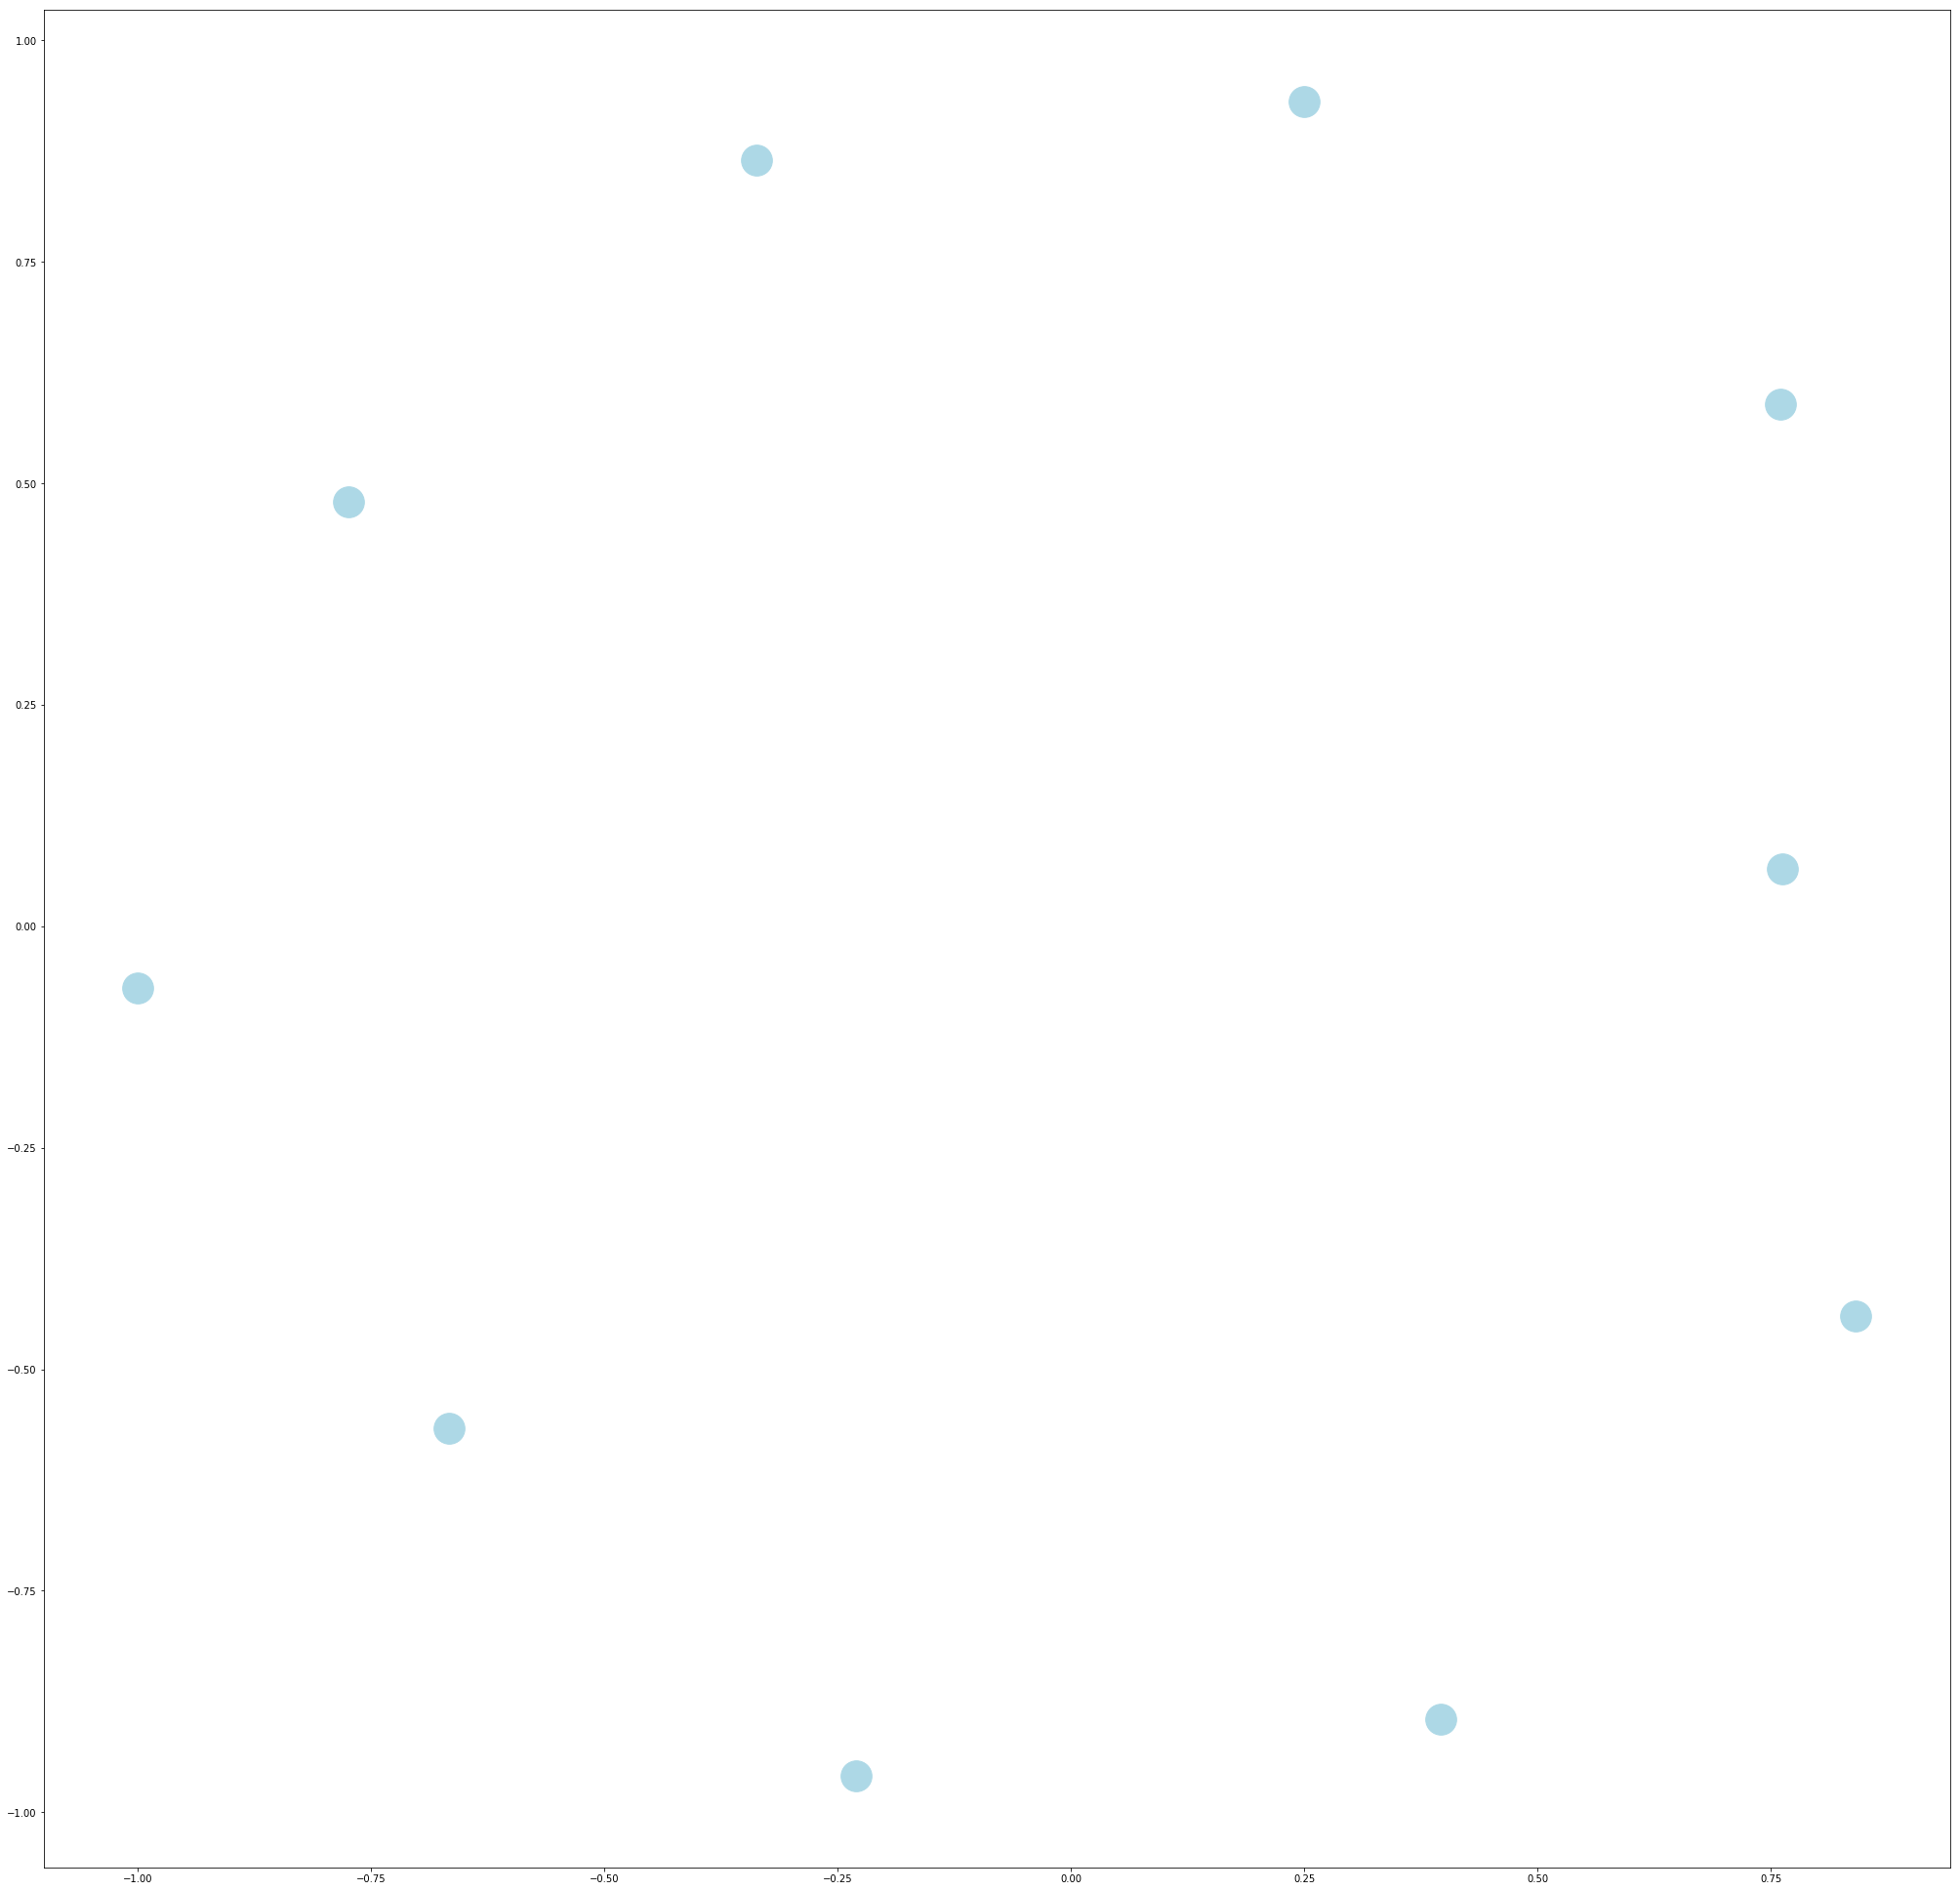

In [10]:
animal_network_measures = dict()

for animal in animal_dataframes:
    # print(animal)
    
    indices = animal_dataframes[animal]["neuron and beh"].loc[animal_dataframes[animal]["neuron and beh"]["OpenArms_centerpoint"] != 0].index
    open_arms_graph = gau.create_graph(animal_dataframes[animal]["cell transients"].iloc[indices])
    gau.plot_graph(open_arms_graph)
    
    indices = animal_dataframes[animal]["neuron and beh"].loc[animal_dataframes[animal]["neuron and beh"]["ClosedArms_centerpoint"] != 0].index
    closed_arms_graph = gau.create_graph(animal_dataframes[animal]["cell transients"].iloc[indices])
    gau.plot_graph(closed_arms_graph)
    
    animal_network_measures[animal] = {"open betw cent": gau.compute_mean_betweenness_centrality(open_arms_graph)}
    animal_network_measures[animal].update({"closed betw cent": gau.compute_mean_betweenness_centrality(closed_arms_graph)})
    
    animal_network_measures[animal].update({"open deg cent": gau.compute_mean_degree_centrality(open_arms_graph)})
    animal_network_measures[animal].update({"closed deg cent": gau.compute_mean_degree_centrality(closed_arms_graph)})
    
    animal_network_measures[animal].update({"open load cent": gau.compute_mean_load_centrality(open_arms_graph)})
    animal_network_measures[animal].update({"closed load cent": gau.compute_mean_load_centrality(closed_arms_graph)})
    
    animal_network_measures[animal].update({"open avg clust coeff": nx.average_clustering(open_arms_graph)})
    animal_network_measures[animal].update({"closed avg clust coeff": nx.average_clustering(closed_arms_graph)})
    
    animal_network_measures[animal].update({"open max clique size": gau.get_max_clique_size(open_arms_graph)})
    animal_network_measures[animal].update({"closed max clique size": gau.get_max_clique_size(closed_arms_graph)})
    
    animal_network_measures[animal].update({"open connection density": gau.compute_connection_density(open_arms_graph)})
    animal_network_measures[animal].update({"closed connection density": gau.compute_connection_density(closed_arms_graph)})
    
    animal_network_measures[animal].update({"open local efficiency": nx.local_efficiency(open_arms_graph)})
    animal_network_measures[animal].update({"closed local efficiency": nx.local_efficiency(closed_arms_graph)})
    animal_network_measures[animal].update({"open global efficiency": nx.global_efficiency(open_arms_graph)})
    animal_network_measures[animal].update({"closed global efficiency": nx.global_efficiency(closed_arms_graph)})

In [ ]:
animal_

In [6]:
animal_network_measures

{'drd46': {'closed avg clust coeff': 0.2333333333333333,
  'closed betw cent': 0.005555555555555555,
  'closed connection density': 0.08888888888888889,
  'closed deg cent': 0.08888888888888888,
  'closed global efficiency': 0.1111111111111111,
  'closed load cent': 0.005555555555555555,
  'closed local efficiency': 0.38333333333333336,
  'closed max clique size': 3,
  'open avg clust coeff': 0.0,
  'open betw cent': 0.0,
  'open connection density': 0.0,
  'open deg cent': 0.0,
  'open global efficiency': 0.0,
  'open load cent': 0.0,
  'open local efficiency': 0.0,
  'open max clique size': 1},
 'drd73': {'closed avg clust coeff': 0.29166666666666663,
  'closed betw cent': 0.0023402523402523403,
  'closed connection density': 0.042328042328042326,
  'closed deg cent': 0.042328042328042326,
  'closed global efficiency': 0.057539682539682536,
  'closed load cent': 0.0023402523402523403,
  'closed local efficiency': 0.6577380952380952,
  'closed max clique size': 3,
  'open avg clust co

In [7]:
import plotly
import plotly.graph_objs as go

def plot_network_measures(y, y2, title):

    x = ["drd87", "drd73", "drd77", "drd46"]
    
    trace1 = go.Bar(
        x=x,
        y=y,
        text=y,
        textposition = 'auto',
        name="Open Arms",
        marker=dict(
            color='rgb(255, 0, 0)',
            line=dict(
                color='rgb(180, 0, 0)',
                width=1.5),
            ),
        opacity=0.6
    )

    trace2 = go.Bar(
        x=x,
        y=y2,
        text=y2,
        textposition = 'auto',
        name="Closed Arms",
        marker=dict(
            color='rgb(58,200,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5),
            ),
        opacity=0.6
    )

    data = [trace1, trace2]
    layout = go.Layout(
        title=title,
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

In [8]:
titles = ["Mean Betweeness Centrality", "Mean Degree Centrality", "Mean Load Centrality", "Avg Clustering Coefficient", "Max Clique Size", "Connection Density", "Local Efficiency", "Global Efficiency"]
mice_names = ["drd87", "drd73", "drd77", "drd46"]
y = []
y2 = []
for mouse_name in mice_names:
    y.append(animal_network_measures[mouse_name]["open betw cent"])
    y2.append(animal_network_measures[mouse_name]["closed betw cent"])

plot_network_measures(y, y2, titles[0])

y = []
y2 = []
for mouse_name in mice_names:
    y.append(animal_network_measures[mouse_name]["open deg cent"])
    y2.append(animal_network_measures[mouse_name]["closed deg cent"])

plot_network_measures(y, y2, titles[1])

y = []
y2 = []
for mouse_name in mice_names:
    y.append(animal_network_measures[mouse_name]["open load cent"])
    y2.append(animal_network_measures[mouse_name]["closed load cent"])

plot_network_measures(y, y2, titles[2])

y = []
y2 = []
for mouse_name in mice_names:
    y.append(animal_network_measures[mouse_name]["open avg clust coeff"])
    y2.append(animal_network_measures[mouse_name]["closed avg clust coeff"])

plot_network_measures(y, y2, titles[3])

y = []
y2 = []
for mouse_name in mice_names:
    y.append(animal_network_measures[mouse_name]["open max clique size"])
    y2.append(animal_network_measures[mouse_name]["closed max clique size"])

plot_network_measures(y, y2, titles[4])

y = []
y2 = []
for mouse_name in mice_names:
    y.append(animal_network_measures[mouse_name]["open connection density"])
    y2.append(animal_network_measures[mouse_name]["closed connection density"])

plot_network_measures(y, y2, titles[5])

y = []
y2 = []
for mouse_name in mice_names:
    y.append(animal_network_measures[mouse_name]["open local efficiency"])
    y2.append(animal_network_measures[mouse_name]["closed local efficiency"])

plot_network_measures(y, y2, titles[6])

y = []
y2 = []
for mouse_name in mice_names:
    y.append(animal_network_measures[mouse_name]["open global efficiency"])
    y2.append(animal_network_measures[mouse_name]["closed global efficiency"])

plot_network_measures(y, y2, titles[7])